## XGBoost
examples : https://unit8co.github.io/darts/examples/01-multi-time-series-and-covariates.html
model comparaison: https://unit8.com/resources/darts-time-series-made-easy-in-python/


## Load packages

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%cd ..

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/marthygarcia/Documents/GitHub


In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [18]:
import pandas as pd
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler
#from darts.models import NaiveMean, LinearRegressionModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.timeseries_generation import linear_timeseries
from darts.metrics import mape

In [19]:
# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

# Exchange Rate Data

## ETL & Preprocessing

In [20]:
DATA_PATH = r'/Users/marthygarcia/Documents/GitHub/IFT6759_B_H23/data/interim/exchange_rate/exchange_rate.txt'

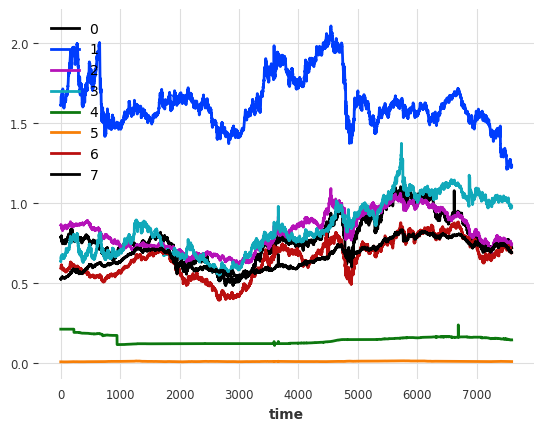

In [21]:
series_exrate= TimeSeries.from_csv(DATA_PATH, header=None)
series_exrate.plot()

In [22]:
df = pd.read_csv(DATA_PATH,header=None)
#df=df.iloc[:,0]
df.head()

,0,1,2,3,4,5,6,7
0,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
2,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
3,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
4,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


In [23]:
df.shape

(7588, 8)

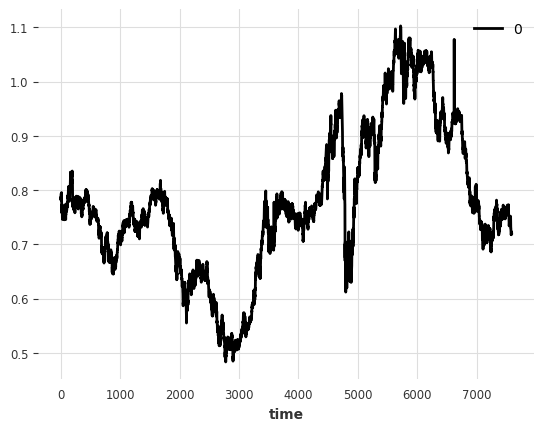

In [25]:
data_exrate = series_exrate.univariate_component(0)
data_exrate.plot()

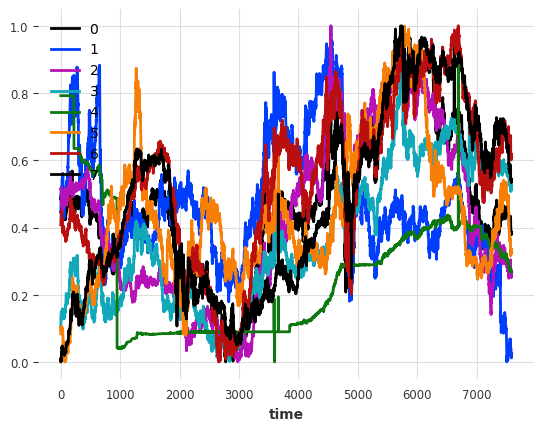

In [27]:
scaler_exrate= Scaler()
series_exrate_scaled = scaler_exrate.fit_transform(series_exrate)
series_exrate_scaled.plot()

In [ ]:
# we wonly keep the 80% of the first observed data, we keep the latest 20% observed data to avoid
#look-ahead bias

In [28]:

#training, validation = series.split_before(pd.Timestamp("1973-01-01"))
#Let’s keep the last 36 months of both series as validation:
#train, test = data_exrate[:-6070], data_exrate[-6070:]
#train, valid = data_exrate[:-45530], data_exrate[-45530:]
train, test = data_exrate.split_before(0.80) 
train, valid = train.split_before(0.75)

## Create model

In [29]:
# specify parameters via map
# param = {'booster': 'dart',
#          'max_depth': 5, 'learning_rate': 0.1,
#          'objective': 'binary:logistic',
#          'sample_type': 'uniform',
#          'normalize_type': 'tree',
#          'rate_drop': 0.1,
#          'skip_drop': 0.5}

add_encoders={
    # 'cyclic': {'future': ['month']},
    # 'datetime_attribute': {'future': ['hour', 'dayofweek']},
    # 'position': {'past': ['relative'], 'future': ['relative']},
    # 'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
    'transformer': Scaler()
}

In [35]:
from darts.models.forecasting.xgboost import XGBModel
model_xgboost = XGBModel(lags=1)#, add_encoders=add_encoders
model_xgboost.fit(train)
prediction_xgboost = model_xgboost.predict(len(valid))

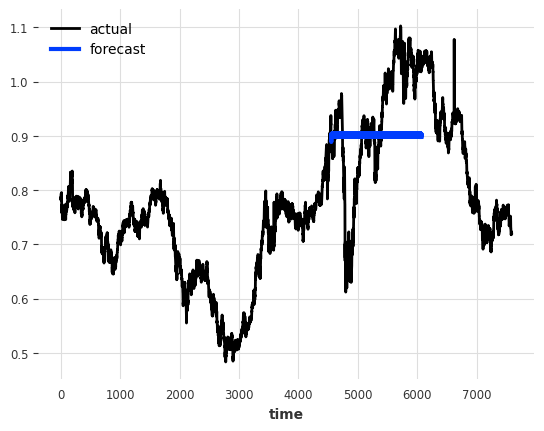

In [36]:
data_exrate.plot(label='actual')
prediction_xgboost.plot(label='forecast', lw=3)
plt.legend()

# Electricity Data

## ETL & Preprocessing

In [43]:
DATA_PATH = r'/Users/marthygarcia/Documents/GitHub/IFT6759_B_H23/data/interim/electricity/electricity.txt'

Number of components is larger than 10 (321). Plotting only the first 10 components.


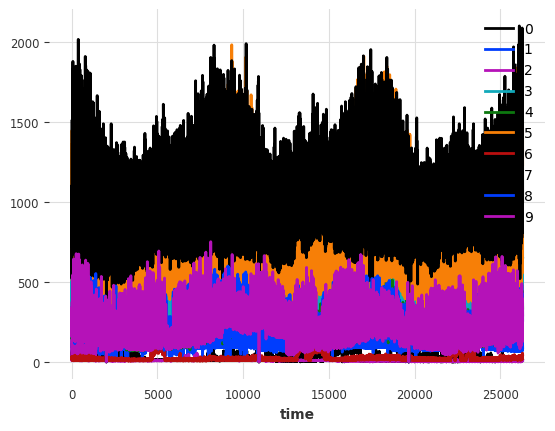

In [44]:
series_elec= TimeSeries.from_csv(DATA_PATH, header=None)
series_elec.plot()

In [45]:
df = pd.read_csv(DATA_PATH,header=None)
#df=df.iloc[:,0]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [46]:
df.shape

(26304, 321)

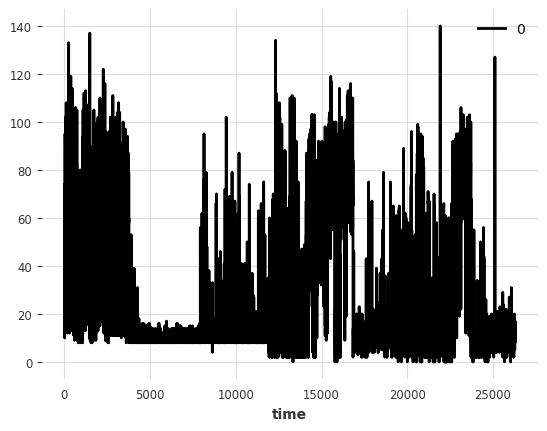

In [47]:
data_elec = series_elec.univariate_component(0)
data_elec.plot()

Number of components is larger than 10 (321). Plotting only the first 10 components.


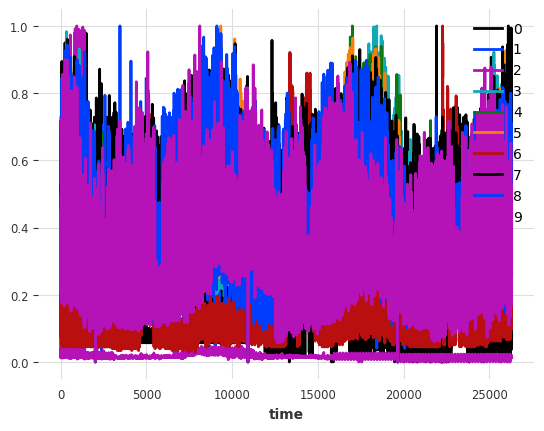

In [48]:
scaler_elec= Scaler()
series_elec_scaled = scaler_elec.fit_transform(series_elec)
series_elec_scaled.plot()

In [49]:
train, test = data_elec.split_before(0.80) 
train, valid = train.split_before(0.75)

## Create Model

In [50]:
add_encoders={
    # 'cyclic': {'future': ['month']},
    # 'datetime_attribute': {'future': ['hour', 'dayofweek']},
    # 'position': {'past': ['relative'], 'future': ['relative']},
    # 'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
    'transformer': Scaler()
}

In [51]:
from darts.models.forecasting.xgboost import XGBModel
model_xgboost = XGBModel(lags=1)#, add_encoders=add_encoders
model_xgboost.fit(train)
prediction_xgboost = model_xgboost.predict(len(valid))

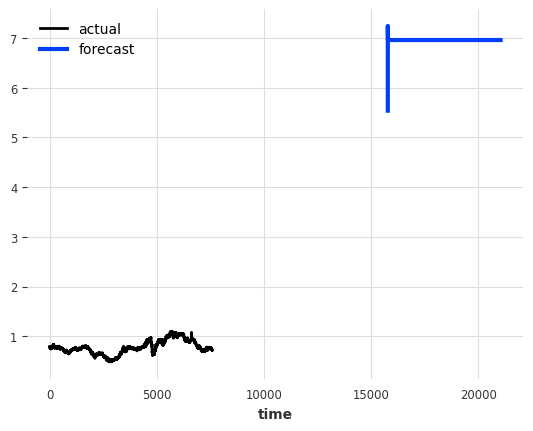

In [52]:
data_exrate.plot(label='actual')
prediction_xgboost.plot(label='forecast', lw=3)
plt.legend()